# First Expiremnt - Transfer learning from ResNet50

## summery

One of the difficulties we are facing in training the network is that we don't have the resources to train the network from scratch. We lack the proccessing power and our data set is not large enough for training the network.


In order to solve that problem, we will use transfer learning from the ResNet50 model into our problem.


In this expirement we will train the ResNet50 model to solve our landscape detection problem.

## Loading training and validation data

We devided the training data to 2 different datasets.
- Training data: The training data will be used to train the model and recalculate the weights 
- Validation data: The validation data will be used to see the network's success on new data.

We use this method in order to prevent over fitting our model. 
The success of our model will be messured by It's preformmance on the Validation data.

* We will set rotation in order to create a larger data set.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

image_size = (128,128)
batch_size = 10

training_data_dir = r'C:\Users\yonba\OneDrive\Desktop\Education\Semester_A_2019\Image_Processing\PhotosDataSet\_Data'
validation_data_dir = r'C:\Users\yonba\OneDrive\Desktop\Education\Semester_A_2019\Image_Processing\PhotosDataSet\_Test'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")


Found 35416 images belonging to 100 classes.
Found 3986 images belonging to 100 classes.


We will show the images to make sure that the loading went well

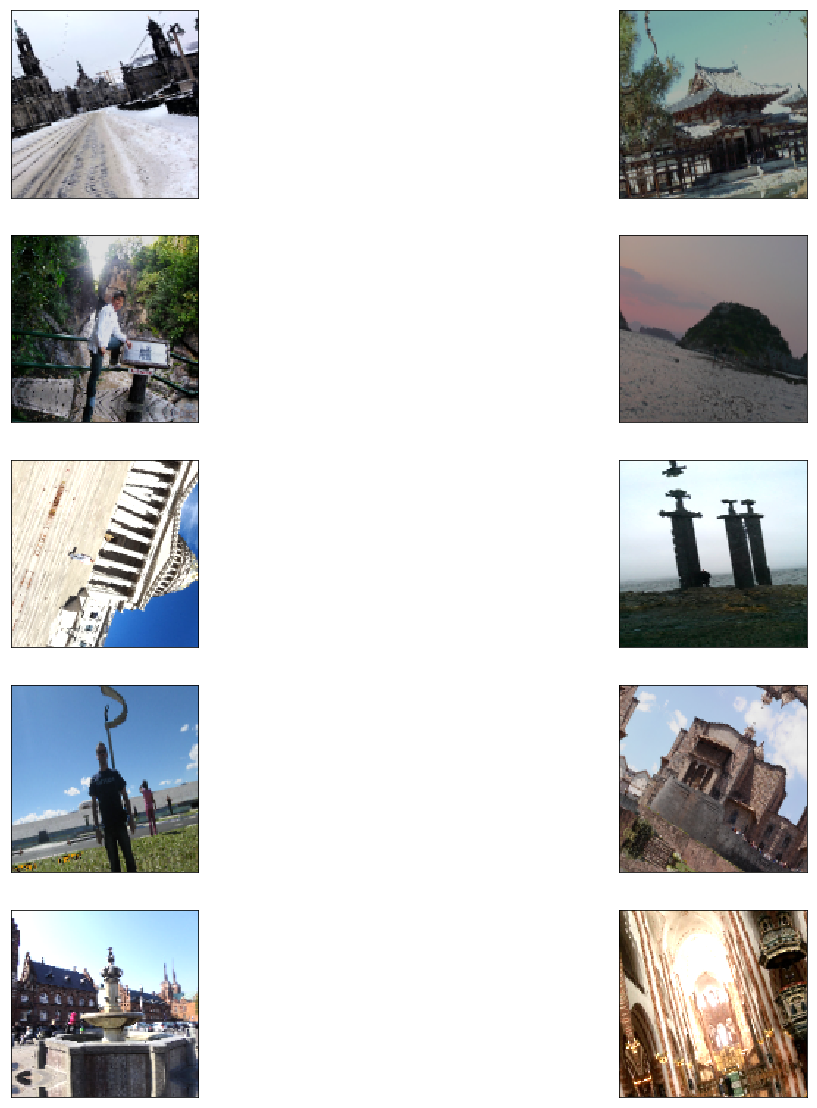

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

## Transfer learning from ResNet50 model

In [3]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

amountOfClasses = 100;

base_model = applications.ResNet50(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))

C:\Users\yonba\Anaconda3\envs\py_36\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


## Adding the dense layers

In [4]:

new_model = base_model.output
new_model= GlobalAveragePooling2D()(new_model)
new_model= Dense(1024, activation='relu')(new_model)
new_model= Dense(1024, activation='relu')(new_model)
new_model= Dense(512, activation='relu')(new_model)
preds= Dense(amountOfClasses, activation='softmax')(new_model)

final_model=Model(inputs=base_model.input, outputs=preds)
final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Configure loss function and optimizer

In [5]:
final_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

## Step Size

In [6]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

3541


## Creating Loss and Accuracy history callbacks

In [7]:
class LossAccHisotry(Callback):
    def on_train_begin(self,logs={}):
        self.loss_history = []
        self.accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
        
    #def on_batch_end(self,batch, logs={}):
        #self.loss_history.append(logs.get('loss'))
        #self.accuracy_history.append(logs.get('acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss_history.append(logs.get('val_loss'))
        self.val_accuracy_history.append(logs.get('val_acc'))
        self.loss_history.append(logs.get('loss'))
        self.accuracy_history.append(logs.get('acc'))
    
history = LossAccHisotry()

## Ignoring images with a bad format

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Setting the network saving time periods

In order to save the model wieghts, we define checkpoint callback that will save the best weights which will be messured by the validation accuracy.

In [9]:
import time

networkfileName = "resnet_exp1_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

## Training the model

In [ ]:
NumberOfEpochs = 10

final_model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=NumberOfEpochs,
                   callbacks = [history, checkpoint])

Epoch 1/10
 129/3541 [>.............................] - ETA: 14:00 - loss: 4.7118 - acc: 0.0109

C:\Users\yonba\Anaconda3\envs\py_36\lib\site-packages\PIL\Image.py:969: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


3540/3541 [============================>.] - ETA: 0s - loss: 4.2410 - acc: 0.1167

C:\Users\yonba\Anaconda3\envs\py_36\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3300917248 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\yonba\Anaconda3\envs\py_36\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5898240 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\yonba\Anaconda3\envs\py_36\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4294901760 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\yonba\Anaconda3\envs\py_36\lib\site-packages\PIL\TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 589824 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\yonba\Anaconda3\envs\py_36\lib\site-packages\PIL\T


Epoch 00001: val_acc improved from -inf to 0.16207, saving model to resnet_exp1_1551533768.h5
3541/3541 [==============================] - 809s 228ms/step - loss: 4.2411 - acc: 0.1167 - val_loss: 3.9312 - val_acc: 0.1621
Epoch 2/10
3540/3541 [============================>.] - ETA: 0s - loss: 3.7998 - acc: 0.1799
Epoch 00002: val_acc improved from 0.16207 to 0.20396, saving model to resnet_exp1_1551533768.h5
3541/3541 [==============================] - 784s 221ms/step - loss: 3.7999 - acc: 0.1799 - val_loss: 3.6065 - val_acc: 0.2040
Epoch 3/10
3540/3541 [============================>.] - ETA: 0s - loss: 3.5437 - acc: 0.2285
Epoch 00003: val_acc improved from 0.20396 to 0.27070, saving model to resnet_exp1_1551533768.h5
3541/3541 [==============================] - 783s 221ms/step - loss: 3.5438 - acc: 0.2285 - val_loss: 3.3411 - val_acc: 0.2707
Epoch 4/10
3540/3541 [============================>.] - ETA: 0s - loss: 3.3155 - acc: 0.2891
Epoch 00004: val_acc improved from 0.27070 to 0.339

## Loss and Accuracy graphs

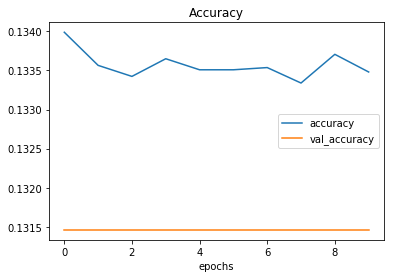

In [23]:
import matplotlib.pyplot as plt
x = range(0, len(history.accuracy_history))
plt.plot(x, history.accuracy_history)
plt.plot(x, history.val_accuracy_history)
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

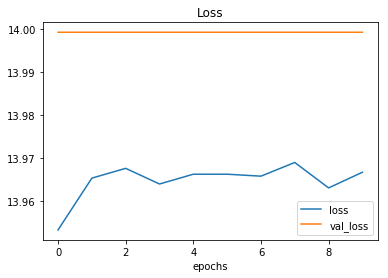

In [24]:
x = range(0, len(history.loss_history))
plt.plot(x, history.loss_history)
plt.plot(x, history.val_loss_history)
plt.xlabel('epochs')
plt.title('Loss')
plt.legend(['loss', 'val_loss'])